# Testing the effect of thresholds on LCA calls

CMS001_059_Ra_S10 has many wolbachia contigs, plus bloodmeal (passeriformes)

CMS001_003_Ra_S2 has a lot going on, including anaplasma

CMS002_045c_Rb_S185_L004 has wuhan 6

CMS002_053a_Rb_S7_L004 has Wuhan 9

CMS001_040_Ra_S21 This one has Narnavirus and divergent peribunyavirus hits

## Load libraries and define functions

In [109]:
import pandas as pd
import numpy as np
import math
import boto3
import os
import matplotlib.pyplot as plt
from pylab import rcParams
import pdb
from lca_functions import *

In [2]:
s3 = boto3.client('s3')
s3_bucket = "czbiohub-mosquito"

In [3]:
def get_blast_file (sample_names, ntnr):
    blast_fn = [x+"_blast_"+ntnr+".m9" for x in sample_names]
    blast = pd.concat([pd.read_csv(x, comment="#", header=0, sep="\t").assign(sample=sample_names[i]) for i, x in enumerate(blast_fn)])
    blast = blast.assign(qlen=blast["query"].str.split("_").apply(lambda x: int(x[3])))
    blast = blast.assign(identity_qcov=blast["identity"]/100*blast["qcov"])
    if (ntnr=="nr"):
        blast = blast.assign(qcov=blast["qcov"]*3, align_length=blast["align_length"]*3)
    blast["qcov"] = blast["qcov"].apply(lambda x: 1 if x > 1 else x)
    blast = blast.assign(identity_qcov=blast["identity"]/100*blast["qcov"])
    return (blast)

In [4]:
def keep_only_discordant_taxids (blast):
    multiple_taxids = blast.groupby(["query"]).apply(lambda x: len(x["taxid"].unique()))>1
    queries_to_keep = list(multiple_taxids.index[multiple_taxids])
    return (blast[blast["query"].isin(queries_to_keep)])

In [83]:
def threshold_func1(metrics, threshold, top_hit):
    max_identity_qcov = top_hit["identity_qcov"].iloc[0]
    return (metrics >= max_identity_qcov*threshold)

def threshold_func2(metrics, threshold, top_hit):
    max_identity_qcov = top_hit["identity_qcov"].iloc[0]
    return (metrics >= (max_identity_qcov-(1-max_identity_qcov)*threshold))

def threshold_func3(metrics, threshold, top_hit):
    max_identity = top_hit["identity"].iloc[0]/100
    max_qcov = top_hit["qcov"].iloc[0]
    return (metrics >= ((max_identity-(1-max_identity)*threshold)*max_qcov))


def test_lca_movement (blast_rows, test_range, threshold_func):
    blast_rows = blast_rows.reset_index()
    blast_rows = blast_rows[blast_rows["taxid"]>0]
    max_identity_qcov = blast_rows["identity_qcov"].max()
    best_blast_rows = blast_rows[blast_rows["identity_qcov"]==max_identity_qcov]
    best_lca = get_lca(best_blast_rows)["taxid"].iloc[0]
    best_row = best_blast_rows.head(n=1)
    best_lineage = ncbi.get_lineage(best_lca)
    best_lineage.reverse()
    try:
        row_indices = [str(list(blast_rows.index[threshold_func(blast_rows["identity_qcov"], x, best_row)])) for x in test_range]
    except:
        pdb.set_trace()
    unique_row_indices = list(set(row_indices))
    try:
        unique_lca = [get_lca(blast_rows.iloc[(eval(x))])["taxid"] if len(eval(x))>0 else best_lca for x in unique_row_indices]
    except:
        pdb.set_trace()
    unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
    lca_movement = [unique_lca_movement[unique_row_indices.index(x)] for x in row_indices]
    lca = [best_lineage[x] for x in lca_movement]
    lca_movement = [x-min(lca_movement) for x in lca_movement]
    output_df = pd.DataFrame({"sample":[blast_rows["sample"].iloc[0]]*len(test_range),
                              "query":[blast_rows["query"].iloc[0]]*len(test_range),
                              "qlen":[blast_rows["qlen"].iloc[0]]*len(test_range),
                              "best_identity_qcov":[max_identity_qcov]*len(test_range),
#                               "identity_qcov":test_range*best_row["identity_qcov"].iloc[0],
                              "threshold":test_range,
                              "lca_movement":lca_movement,
                              "lca":lca,
                              "row_indices":row_indices
                             }
                            )
    return (output_df)
    

In [6]:
def remove_hexapoda (lca):
    test = lca.groupby(["sample", "query"]).apply(lambda x: x["lca"].apply(lambda y: 6960 in ncbi.get_lineage(y)).any()).reset_index(name="exclude")
    output = pd.merge(test[~test["exclude"]].drop(columns="exclude"), lca, how="left", on=["sample", "query"])
    return (output)

In [7]:
def plot_lca_movement(df, ax, xlabel=None, ylabel=None, title=None):
    df.groupby(["sample", "query"]).apply(lambda x: ax.plot(x["identity_qcov_prop"], x["lca_movement"]))
    if (xlabel is not None):
        ax.set_xlabel(xlabel)
    if (ylabel is not None):
        ax.set_ylabel(ylabel)
    if (title is not None):
        ax.set_title(title)



In [8]:
def plot_by_max_metric(df, ntnr, figwidth=10, figheight=10):
    rcParams['figure.figsize'] = figwidth, figheight
    fig = plt.figure()
    metric_range = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95]
    fig, axs = plt.subplots(len(metric_range), 1)
    for i, qlen in enumerate(metric_range):
        metric_list = df["identity_qcov"]
        lower = metric_range[i]
        try:
            upper = qlen_limits[i+1]
            subdf = df[(metric_list > lower) & (metric_list <= upper)]
        except:
            subdf = df[metric_list > lower]
        plot_title = ntnr+": max identity_qcov between "+str(lower)+" and "+str(upper)
        if (i==len(metric_range)):
            plot_lca_movement(subdf, axs[i], 
                              xlabel="Proportion of max(identity_qcov)",
                              title=plot_title
                             )
        elif(i==int(len(qlen_limits)/2)):
            plot_lca_movement(subdf, axs[i],
                              ylabel="Increase in taxonomic level relative to species",
                              title=plot_title
                             )
        else:
            plot_lca_movement(subdf, axs[i],
                              title=plot_title
                             )
        axs[i].set_xlim([df["identity_qcov_prop"].min(), 1])
        axs[i].set_ylim([df["lca_movement"].min(), df["lca_movement"].max()])


## Analysis

In [77]:
test_samples = ["CMS001_059_Ra_S10", "CMS001_003_Ra_S2", "CMS002_045c_Rb_S185_L004", "CMS002_053a_Rb_S7_L004", "CMS001_040_Ra_S21"]
[print("parallel python lca_analysis2.py --blast_type "+ntnr+" --fpath s3://czbiohub-mosquito/contigs/{}/blast_"+ntnr+".m9 --outpath {}_blast_"+ntnr+".m9 --verbose True ::: "+' '.join(test_samples)) for  ntnr in ["nt", "nr"]]

parallel python lca_analysis2.py --blast_type nt --fpath s3://czbiohub-mosquito/contigs/{}/blast_nt.m9 --outpath {}_blast_nt.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21
parallel python lca_analysis2.py --blast_type nr --fpath s3://czbiohub-mosquito/contigs/{}/blast_nr.m9 --outpath {}_blast_nr.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21


[None, None]

In [ ]:
%%bash
#parallel python lca_analysis2.py --blast_type nt --fpath s3://czbiohub-mosquito/contigs/{}/blast_nt.m9 --outpath {}_blastnt.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21
#parallel python lca_analysis2.py --blast_type nr --fpath s3://czbiohub-mosquito/contigs/{}/blast_nr.m9 --outpath {}_blastnr.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21

Import blast_nt/nr_filtered.m9 files from the contig_quality folders:

In [55]:
#blast_nt = get_blast_file(test_samples, "nt")
blast_nt = pd.read_csv("just_059.m9", sep="\t", comment="#", header=None, 
                       names=["query", "subject", "identity", "align_length", "mismatches", 
        "gaps", "qstart", "qend", "sstart", "send", "evalue", "bitscore", "taxid", 
        "sci_name", "common_name", "subject_title"])
blast_nt = blast_nt.assign(qlen=blast_nt["query"].str.split("~").apply(lambda x: x[1]).str.split("_").apply(lambda x: int(x[3])))
blast_nt = blast_nt.assign(qcov=(blast_nt["align_length"]-blast_nt["gaps"])/blast_nt["qlen"])
blast_nt = blast_nt.assign(identity_qcov=blast_nt["identity"]/100*blast_nt["qcov"])
blast_nt = blast_nt.assign(sample=blast_nt["query"].str.split("~").apply(lambda x: x[0]))
blast_nt = blast_nt.assign(query=blast_nt["query"].str.split("~").apply(lambda x: x[1]))



In [79]:
blast_nr = get_blast_file([test_samples[0]], "nr")

Keep only the queries for which there are discordant blast hits with regards to taxid calls

In [80]:
blast_nt_multiples = keep_only_discordant_taxids(blast_nt)
blast_nr_multiples = keep_only_discordant_taxids(blast_nr)

Using the identity x query coverage (identity_qcov) metric, keep only blast hits with identity_qcov >= threshold x max(identity_qcov) for that query. Compute the LCA based on these blast hits. Evaluate for different thresholds between 0.8-1 to see how much the LCA result changes with different thresholds.

In [81]:
threshold_functions = [threshold_func1, threshold_func2, threshold_func3]
threshold_test_range = [np.linspace(1, 0.8, 21), np.linspace(0, 1, 11), np.linspace(0, 1, 11)]


In [58]:
blast_nt_lca_movement = [blast_nt_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range[i], threshold_func=func) for i, func in enumerate(threshold_functions)]

In [59]:
blast_nt_lca_movement_nohex = [remove_hexapoda(x) for x in blast_nt_lca_movement]

In [60]:
lca_movements_nt = pd.concat([x.groupby(["sample", "query"])["lca_movement"].max() for x in blast_nt_lca_movement_nohex], axis=1).reset_index()
lca_movements_nt[lca_movements_nt.iloc[:, range(2, len(threshold_functions)+2)].apply(lambda x: ~(x==0).all(), axis=1)]
lca_movements_nt[lca_movements_nt.iloc[:, 2]>lca_movements_nt.iloc[:, 4]*2]

,sample,query,lca_movement,lca_movement,lca_movement
0,CMS001_059_Ra_S10,NODE_1015_length_242_cov_0.981818,2,0,0
3,CMS001_059_Ra_S10,NODE_102_length_515_cov_43.271689,25,0,0
4,CMS001_059_Ra_S10,NODE_1030_length_241_cov_1.335366,2,0,0
5,CMS001_059_Ra_S10,NODE_103_length_514_cov_1.231121,2,0,0
6,CMS001_059_Ra_S10,NODE_1066_length_239_cov_1.753086,9,0,0
...,...,...,...,...,...
192,CMS001_059_Ra_S10,NODE_916_length_248_cov_1.707602,9,0,0
193,CMS001_059_Ra_S10,NODE_94_length_534_cov_94.245077,21,4,4
195,CMS001_059_Ra_S10,NODE_980_length_244_cov_81.844311,20,12,0
196,CMS001_059_Ra_S10,NODE_983_length_244_cov_1.311377,2,0,0


In [61]:
nt_test_contig_names_001_059 = ["NODE_27_length_855_cov_38.371465", "NODE_6_length_2269_cov_25.770073", "NODE_26_length_880_cov_13.112080", "NODE_7_length_1837_cov_576.351136", "NODE_20_length_1036_cov_299.052138", "NODE_154_length_435_cov_1.494413"]
lca_movements_nt[lca_movements_nt["query"].isin(nt_test_contig_names_001_059)]

,sample,query,lca_movement,lca_movement,lca_movement
32,CMS001_059_Ra_S10,NODE_154_length_435_cov_1.494413,2,0,0
47,CMS001_059_Ra_S10,NODE_20_length_1036_cov_299.052138,8,2,2
72,CMS001_059_Ra_S10,NODE_26_length_880_cov_13.112080,3,0,0
75,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,25,20,4
166,CMS001_059_Ra_S10,NODE_6_length_2269_cov_25.770073,3,3,3
174,CMS001_059_Ra_S10,NODE_7_length_1837_cov_576.351136,4,0,0


In [62]:
[blast_nt[blast_nt["query"]==x] for x in nt_test_contig_names_001_059]

[                                 query         subject  identity  \
 6354  NODE_27_length_855_cov_38.371465      MG590304.1    98.311   
 6355  NODE_27_length_855_cov_38.371465      MG590305.1    98.070   
 6356  NODE_27_length_855_cov_38.371465      MG590323.1    97.829   
 6357  NODE_27_length_855_cov_38.371465      MG590322.1    97.829   
 6358  NODE_27_length_855_cov_38.371465      MG590321.1    97.829   
 ...                                ...             ...       ...   
 7015  NODE_27_length_855_cov_38.371465      GU230897.1    83.732   
 7016  NODE_27_length_855_cov_38.371465      GU230896.1    83.215   
 7017  NODE_27_length_855_cov_38.371465      KT989334.1    83.254   
 7018  NODE_27_length_855_cov_38.371465  XR_003218708.1    86.951   
 7019  NODE_27_length_855_cov_38.371465      KT989344.1    83.077   
 
       align_length  mismatches  gaps  qstart  qend  sstart  send  evalue  \
 6354           829          14     0       6   834    8717  7889     0.0   
 6355           

In [89]:
blast_nt_lca_movement_nohex[2][blast_nt_lca_movement_nohex[2]["query"]==nt_test_contig_names_001_059[0]]

,sample,query,qlen,best_identity_qcov,threshold,lca_movement,lca,row_indices
825,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.0,0,187106,[0]
826,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.1,0,187106,[0]
827,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.2,2,8930,"[0, 1]"
828,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.3,2,8930,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
829,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.4,2,8930,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
830,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.5,4,8825,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
831,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.6,4,8825,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
832,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.7,4,8825,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
833,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.8,4,8825,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
834,CMS001_059_Ra_S10,NODE_27_length_855_cov_38.371465,855,0.953214,0.9,4,8825,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [88]:
blast_nt[blast_nt["query"]==nt_test_contig_names_001_059[5]].sort_values(by="identity_qcov", ascending=False).head(n=5)

,query,subject,identity,align_length,mismatches,gaps,qstart,qend,sstart,send,evalue,bitscore,taxid,sci_name,common_name,subject_title,qlen,qcov,identity_qcov,sample
22653,NODE_154_length_435_cov_1.494413,AM999887.1,98.851,435,5,0,1,435,958572,958138,0.000000e+00,762.0,570417,NaN,NaN,Wolbachia endosymbiont of Culex quinquefasciat...,435,1.000000,0.988510,CMS001_059_Ra_S10
22654,NODE_154_length_435_cov_1.494413,CP031221.1,97.241,435,12,0,1,435,45863,46297,0.000000e+00,731.0,1116230,NaN,NaN,"Wolbachia pipientis wAlbB chromosome, complete...",435,1.000000,0.972410,CMS001_059_Ra_S10
22655,NODE_154_length_435_cov_1.494413,CP015510.2,85.714,434,59,1,5,435,561255,560822,3.980000e-138,502.0,169402,NaN,NaN,Wolbachia endosymbiont of Folsomia candida str...,435,0.995402,0.853199,CMS001_059_Ra_S10
22656,NODE_154_length_435_cov_1.494413,CP015510.2,69.663,356,102,2,84,433,1340116,1340471,8.250000e-33,152.0,169402,NaN,NaN,Wolbachia endosymbiont of Folsomia candida str...,435,0.813793,0.566913,CMS001_059_Ra_S10


In [ ]:
blast_nr[blast_nr["query"]==nt_test_contig_names_001_059[4]].sort_values(by="identity_qcov", ascending=False).head(n=5)

In [53]:
tempx = blast_nt.groupby(["query"]).apply(lambda x: x["taxid"].iloc[0]==570417)
tempy = blast_nt.groupby(["query"]).first().reset_index()
tempy[tempy["query"].isin(list(tempx.index[tempx]))]["subject"].unique()

array(['AM999887.1', 'NR_076253.1'], dtype=object)

In [84]:
blast_nr_lca_movement = [blast_nr_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range[i], threshold_func=func) for i, func in enumerate(threshold_functions)]

> <ipython-input-83-c2cf46458f7d>(33)test_lca_movement()
-> unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
(Pdb) q
> <ipython-input-83-c2cf46458f7d>(33)test_lca_movement()
-> unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
(Pdb) q
> <ipython-input-83-c2cf46458f7d>(33)test_lca_movement()
-> unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
(Pdb) q
> <ipython-input-83-c2cf46458f7d>(33)test_lca_movement()
-> unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
(Pdb) q


BdbQuit: 

In [ ]:
blast_nr_lca_movement_nohex = [remove_hexapoda(x) for x in blast_nr_lca_movement]

In [ ]:
lca_movements_nr = pd.concat([x.groupby(["sample", "query"])["lca_movement"].max() for x in blast_nr_lca_movement_nohex], axis=1).reset_index()
lca_movements_nr[lca_movements_nr.iloc[:, range(2, len(threshold_functions)+2)].apply(lambda x: ~(x==0).all(), axis=1)]
lca_movements_nr[lca_movements_nr.iloc[:, 2]>lca_movements_nr.iloc[:, 4]*2]

In [294]:
def return_change_point(lca_movements):
    if (lca_movements[-1]==lca_movements[0]):
        return (len(lca_movements)-1)
    for i, x in enumerate(lca_movements):
        if (x>lca_movements[0]):
            break
    return (i)

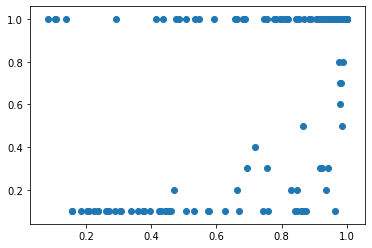

In [295]:
#plt.hist(blast_nr_lca_movement_nohex[1].groupby(["sample", "query"]).apply(lambda x: x["threshold"].iloc[int(return_change_point(x["lca_movement"].tolist()))]).reset_index()[0])
#plt.hist(blast_nr_lca_movement_nohex[1]["qlen"])
plt.scatter(blast_nr_lca_movement_nohex[1].groupby(["sample", "query"])["best_identity_qcov"].first(), blast_nr_lca_movement_nohex[1].groupby(["sample", "query"]).apply(lambda x: x["threshold"].iloc[int(return_change_point(x["lca_movement"].tolist()))]).reset_index()[0])

In [257]:
test_sample_name = "CMS001_003_Ra_S2"
test_contig_name = "NODE_9941_length_269_cov_1.520833"

In [258]:
blast_nr_multiples[(blast_nr_multiples["sample"]==test_sample_name) & (blast_nr_multiples["query"]==test_contig_name)]

,query,subject,identity,align_length,mismatches,gaps,qstart,qend,sstart,send,...,taxid,sci_name,common_name,subject_title,qcov,hsp_count,blast_type,sample,qlen,identity_qcov
11343,NODE_9941_length_269_cov_1.520833,gi|20138428|sp|HBA1_BUBBU|Q9TSN7.3|,91.01,267,8,0,2,268,52,140,...,89462,Bubalus bubalis,water buffalo,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.903333
11344,NODE_9941_length_269_cov_1.520833,gi|110831902|sp|HBA_ALCAA|P01971.2|,96.63,267,3,0,2,268,52,140,...,9853,Alces alces alces,european elk,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.959116
11345,NODE_9941_length_269_cov_1.520833,gi|115502221|sp|HBA_PANHO|Q0ZA50.3|,93.26,267,6,0,2,268,52,140,...,59538,Pantholops hodgsonii,chiru,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.925666
11346,NODE_9941_length_269_cov_1.520833,gi|110831923|sp|HBA_BOSGF|P01969.2|,92.13,267,7,0,2,268,52,140,...,30520,Bos frontalis,gayal,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.914450
11347,NODE_9941_length_269_cov_1.520833,gi|110831922|sp|HBA_BISBO|P09423.2|,92.13,267,7,0,2,268,52,140,...,9902,Bison bonasus,European bison,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.914450
11348,NODE_9941_length_269_cov_1.520833,gi|195927257|pdb|2QU0|65|||2008|8|1|,94.38,267,5,0,2,268,51,139,...,9940,Ovis aries,sheep,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.936783
11349,NODE_9941_length_269_cov_1.520833,gi|1187605762|ref|XP_020755840.1|,98.88,267,1,0,2,268,52,140,...,9880,Odocoileus virginianus texanus,NaN,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.981448
11350,NODE_9941_length_269_cov_1.520833,gi|803279815|ref|XP_011999574.1|,95.51,267,4,0,2,268,52,140,...,9938,Ovis aries musimon,mouflon,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.947999
11351,NODE_9941_length_269_cov_1.520833,gi|1789|embl|CAA49750.1|,95.51,267,4,0,2,268,52,140,...,9940,Ovis aries,sheep,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.947999
11352,NODE_9941_length_269_cov_1.520833,gi|803279817|ref|XP_011999575.1|,94.38,267,5,0,2,268,52,140,...,9938,Ovis aries musimon,mouflon,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.936783


In [259]:
blast_nr_lca_movement_nohex[1][(blast_nr_lca_movement_nohex[1]["sample"]==test_sample_name) & (blast_nr_lca_movement_nohex[1]["query"]==test_contig_name)]

,sample,query,qlen,threshold,lca_movement,lca,row_indices
253,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.0,0,9880,"[6, 12]"
254,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.1,0,9880,"[6, 12]"
255,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.2,0,9880,"[6, 12]"
256,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.3,0,9880,"[6, 12]"
257,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.4,0,9880,"[6, 12]"
258,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.5,0,9880,"[6, 12]"
259,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.6,0,9880,"[6, 12]"
260,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.7,3,9881,"[6, 12, 17]"
261,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.8,3,9881,"[6, 12, 17]"
262,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.9,3,9881,"[6, 12, 17]"


In [260]:
blast_nr_lca_movement_nohex[2][(blast_nr_lca_movement_nohex[2]["sample"]==test_sample_name) & (blast_nr_lca_movement_nohex[2]["query"]==test_contig_name)]

,sample,query,qlen,threshold,lca_movement,lca,row_indices
253,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.0,0,9880,"[6, 12]"
254,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.1,0,9880,"[6, 12]"
255,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.2,0,9880,"[6, 12]"
256,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.3,0,9880,"[6, 12]"
257,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.4,0,9880,"[6, 12]"
258,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.5,0,9880,"[6, 12]"
259,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.6,0,9880,"[6, 12]"
260,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.7,0,9880,"[6, 12]"
261,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.8,0,9880,"[6, 12]"
262,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.9,0,9880,"[6, 12]"


In [ ]:
fig, ax = plt.subplots()
ax.scatter(blast_nt_multiples.groupby(["query"]).apply(lambda x: x["identity_qcov"].max()),
        blast_nt_multiples.groupby(["query"]).apply(lambda x: x["qlen"].max()))


In [ ]:
rcParams['figure.figsize'] = 10, 4
plt.hist(blast_nt_multiples.groupby("query").apply(lambda x: x["identity_qcov"].max()))


In [ ]:
rcParams['figure.figsize'] = 10, 4
plt.hist(blast_nr_multiples.groupby("query").apply(lambda x: x["identity_qcov"].max()), density=True)

In [ ]:
blast_nt_multiples.groupby("query").apply(lambda x: [x["identity_qcov"].max(), x["identity_qcov"].min()])

For each query, plot the changes in LCA level with respect to changes in thresholds.

In [ ]:
plot_by_max_metric(blast_nt_lca_movement, ntnr="nt", figwidth=15, figheight=25)


In [ ]:
plot_by_max_metric(blast_nr_lca_movement, ntnr="nr", figwidth=15, figheight=25)

The LCA moves up the tree as the threshold for keeping blast hits becomes more relaxed. The rate at which the LCA moves up the tree increases with decreasing value of max(identity x query coverage). 

In [119]:
maxpos = 64680927
with open ("list", "r") as f:
    pos = [int(x.rstrip('\n'))-1 for x in list(f.readlines())]
outpos = []
for i in range(0, 64680927, math.ceil(64680927/200)):
    for x in pos:
        if x>i:
            break
    outpos.append(x)
outpos.append(maxpos+1)

with open ("commands", "w") as f:
    for listitem in ["sed -n '"+str(x)+','+str(outpos[i+1]-1)+'p;'+str(outpos[i+1])+"q' admissable_contigs_dc_megablast.m9 > new_blast_nt_"+str(i) for i, x in enumerate(outpos[:-1])]:
        f.write('%s\n' % listitem)





## Results

Go with $iq > (i^*-(1-i^*))q^*$